In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions_GP_Analysis import test_train_split
from bo_functions_GP_Analysis import bo_iter_w_runs
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 1
train_iter = 300
noise_std = 0.1
runs = 20
explore_bias = torch.tensor([0.75])
shuffle_seed = 6
set_lengthscale = None
# t= 20
emulator = True
sparse_grid = True
verbose = True
save_fig=False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  21-Jul-2022 (16:06:45)


Runs: 20
BO Iters: 1
------------------------------
Lengthscale Set To: None
Explore Bias: 0.75
Run Number:  1
Test point is: [1.85665735 0.76582816 1.24174844]


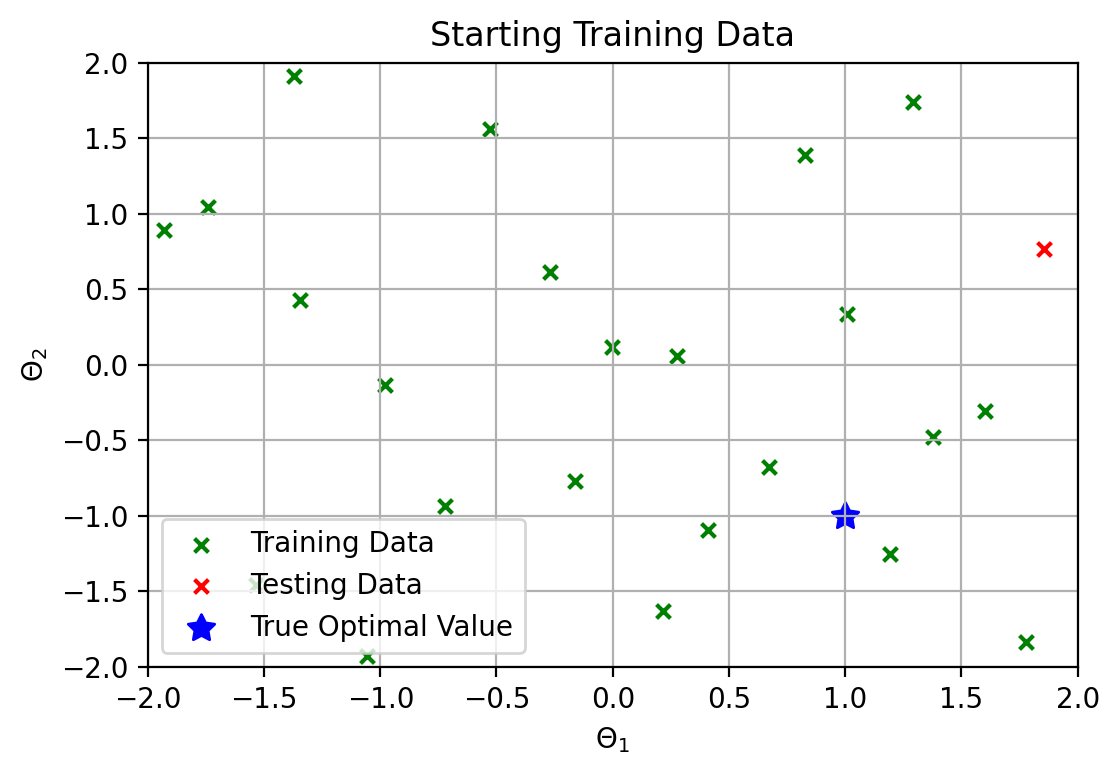

BO Iteration =  1


/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


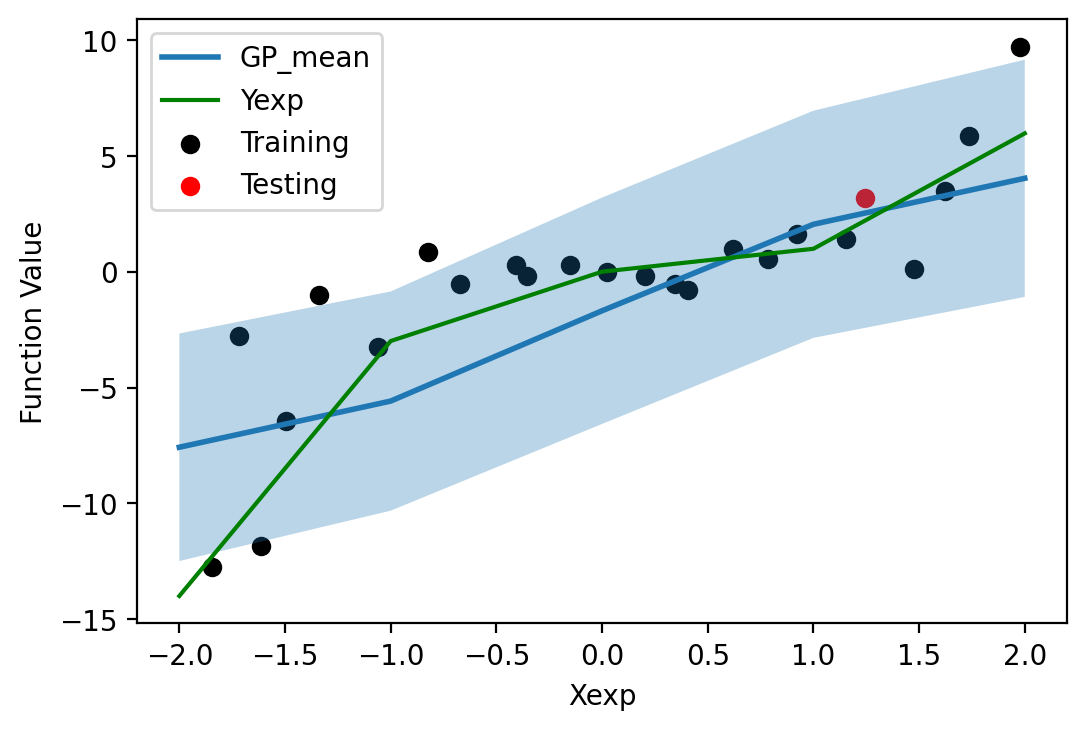

Run Number:  2
Test point is: [-1.53585434 -1.45893398  0.40733209]


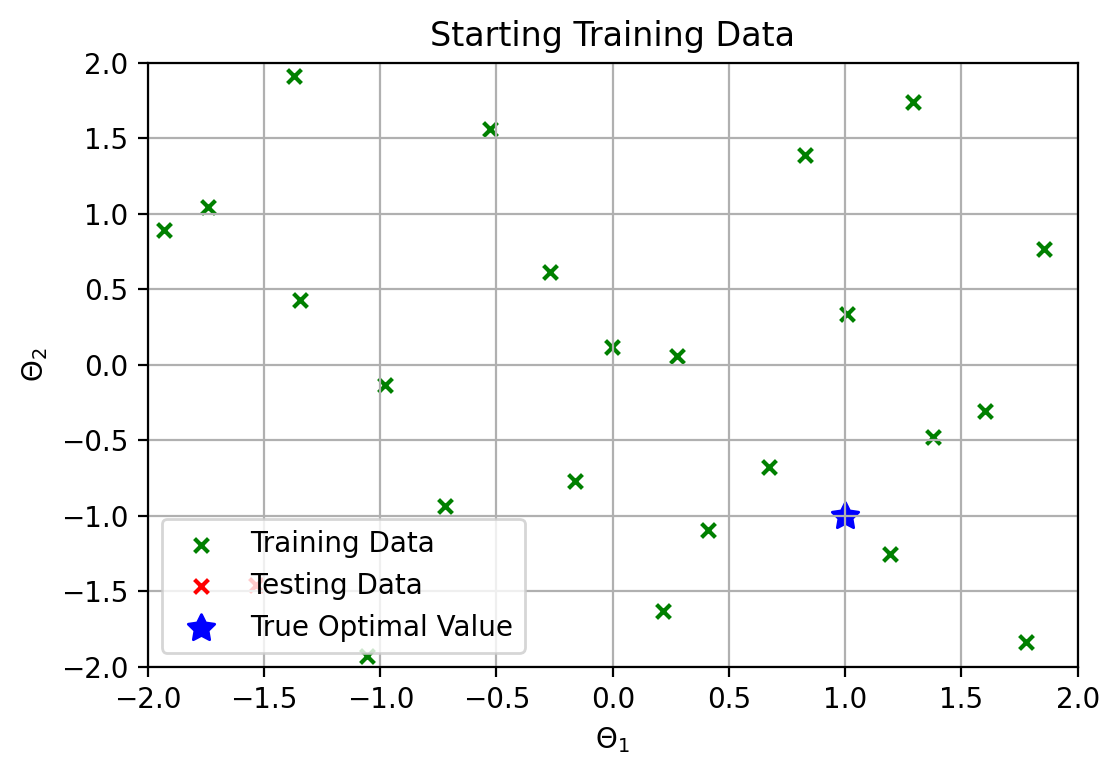

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


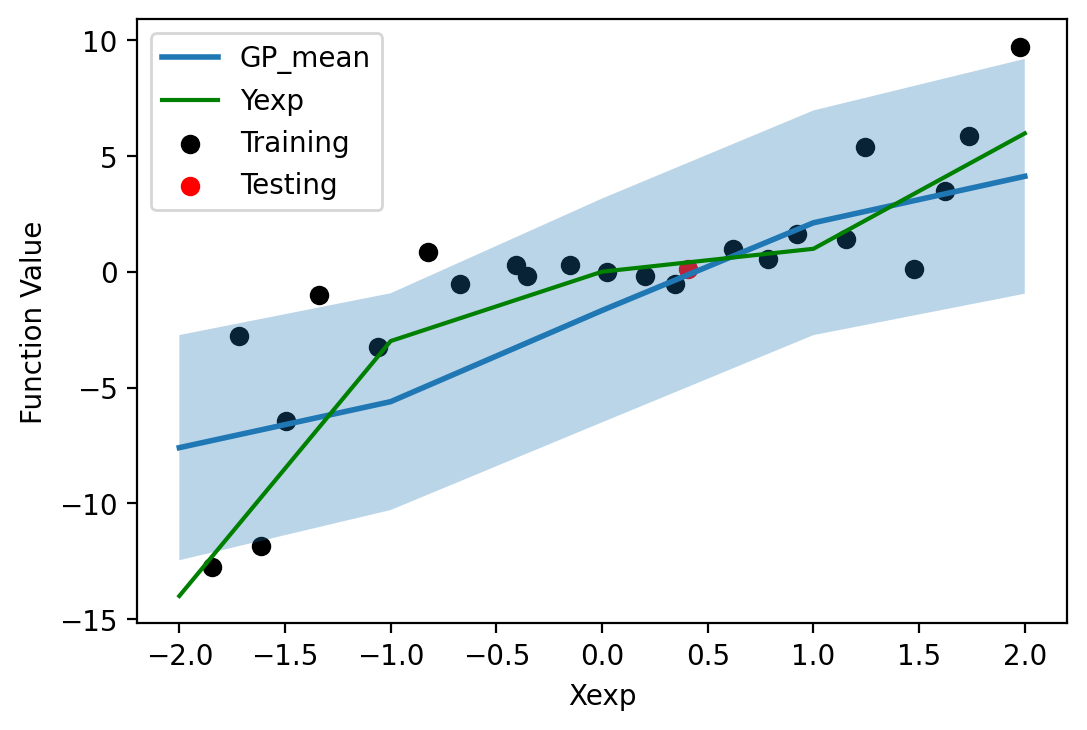

Run Number:  3
Test point is: [ 1.19293351 -1.25492606 -1.84510762]


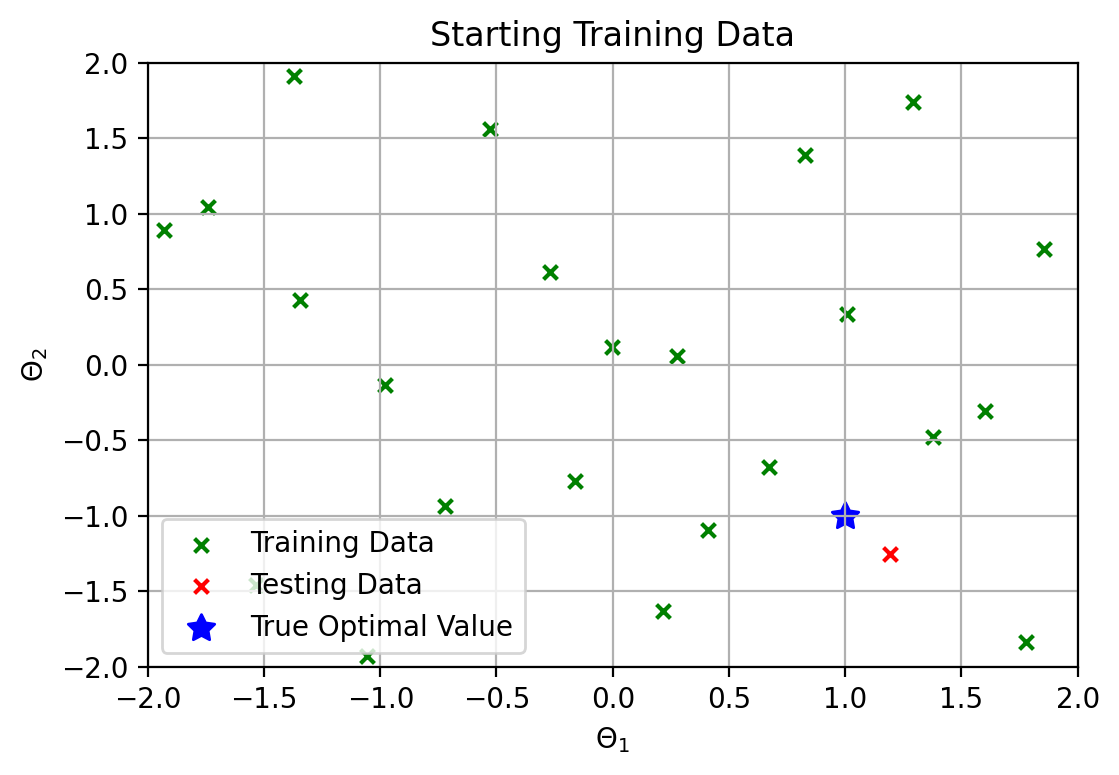

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


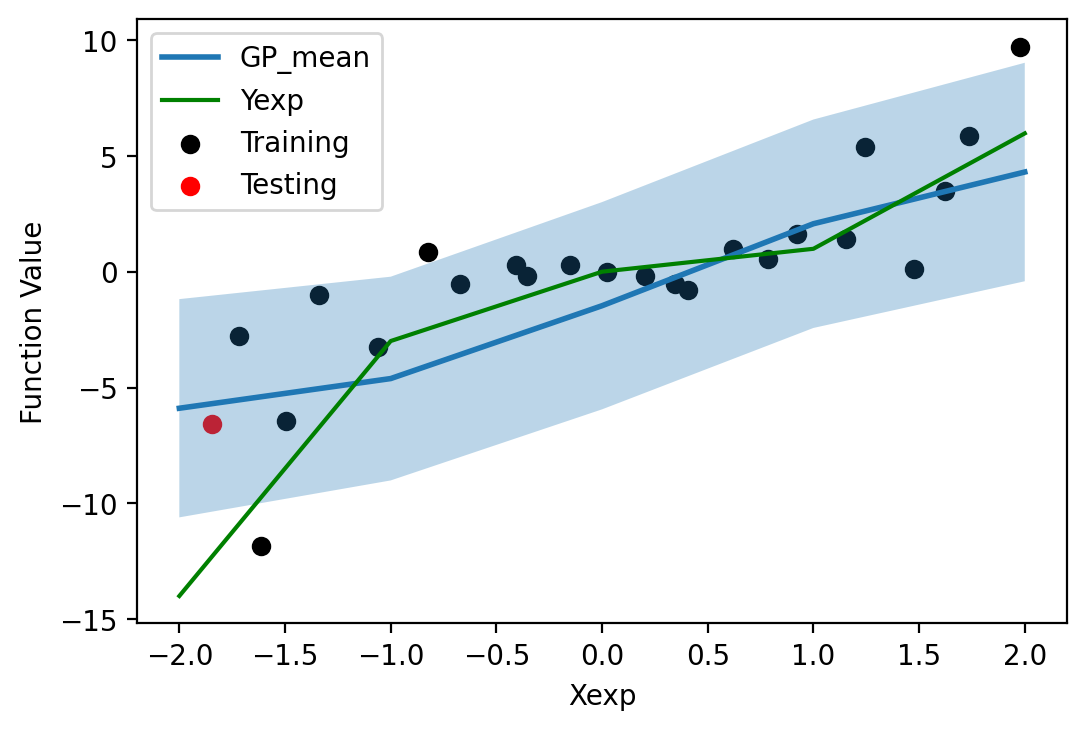

Run Number:  4
Test point is: [-1.92916722  0.89023563  1.62290096]


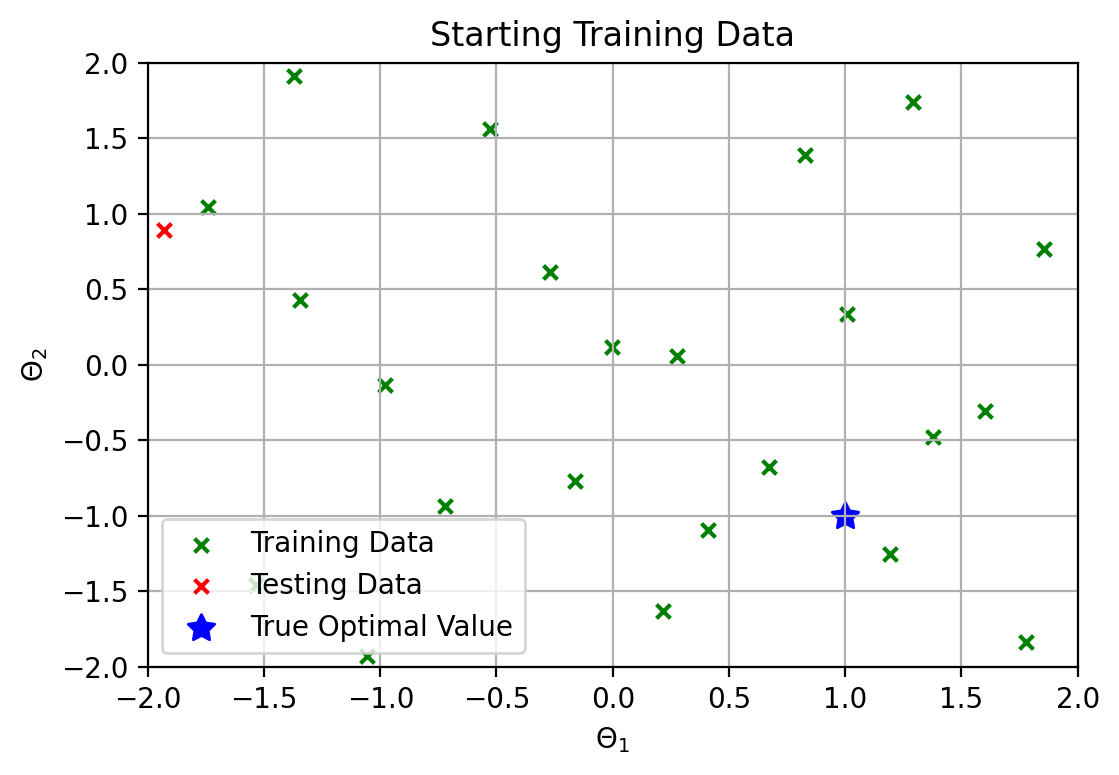

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


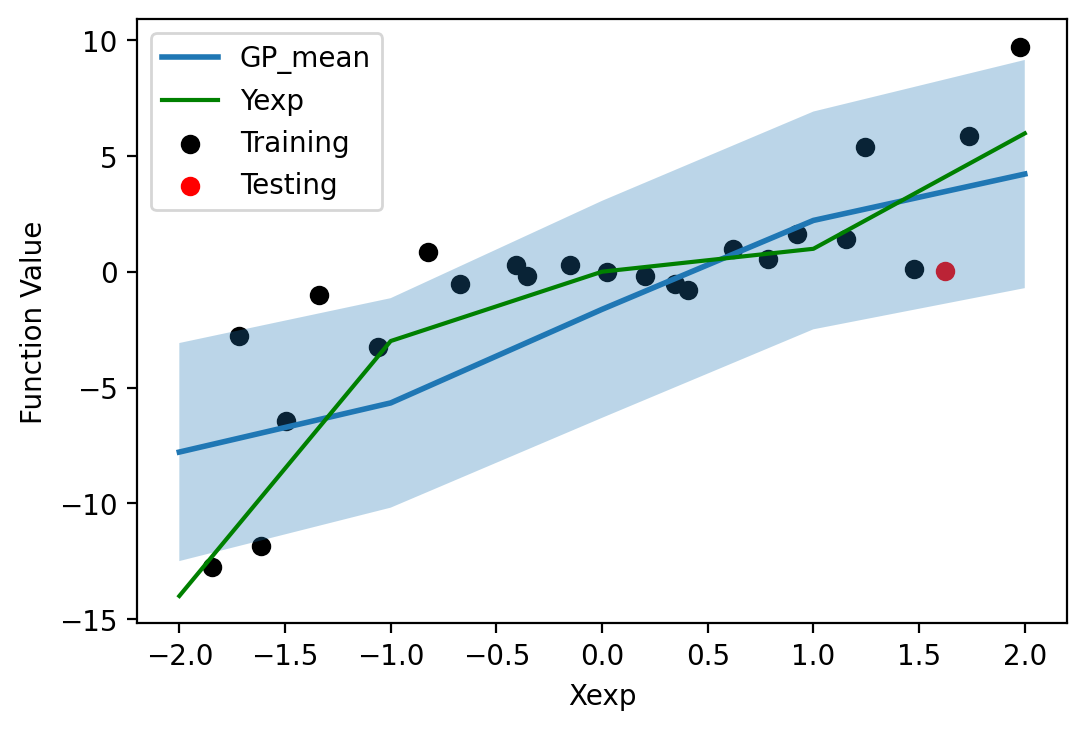

Run Number:  5
Test point is: [0.27640079 0.06003615 1.73397539]


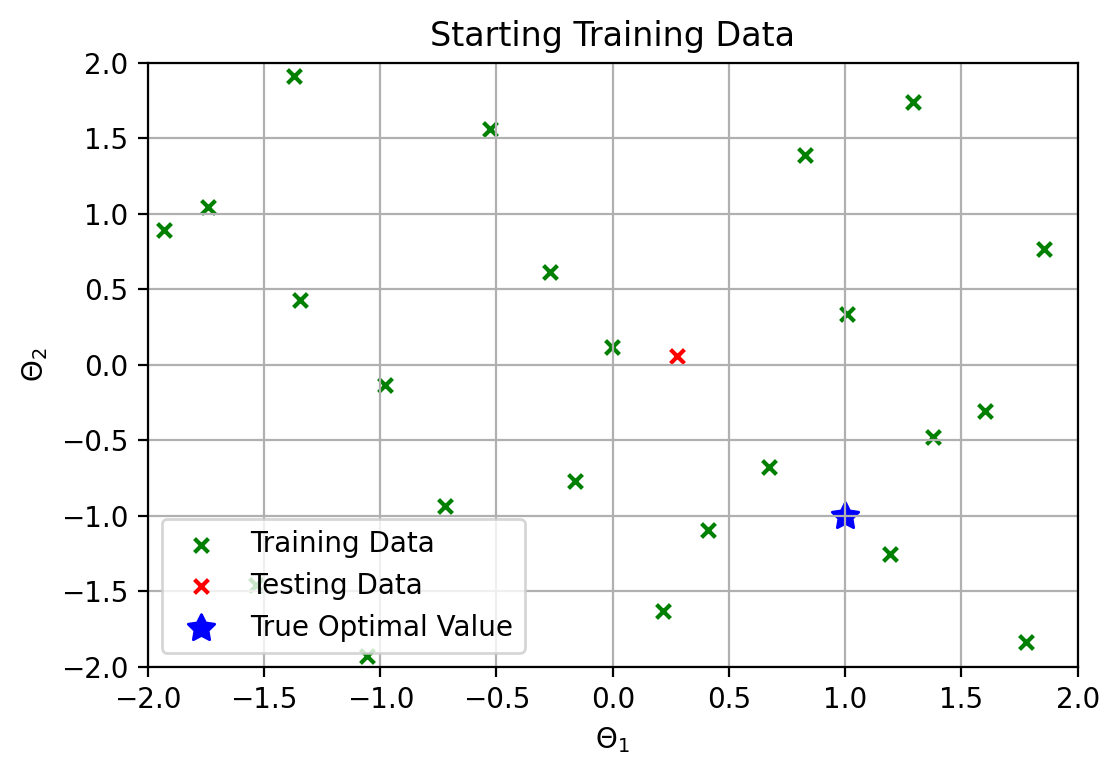

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


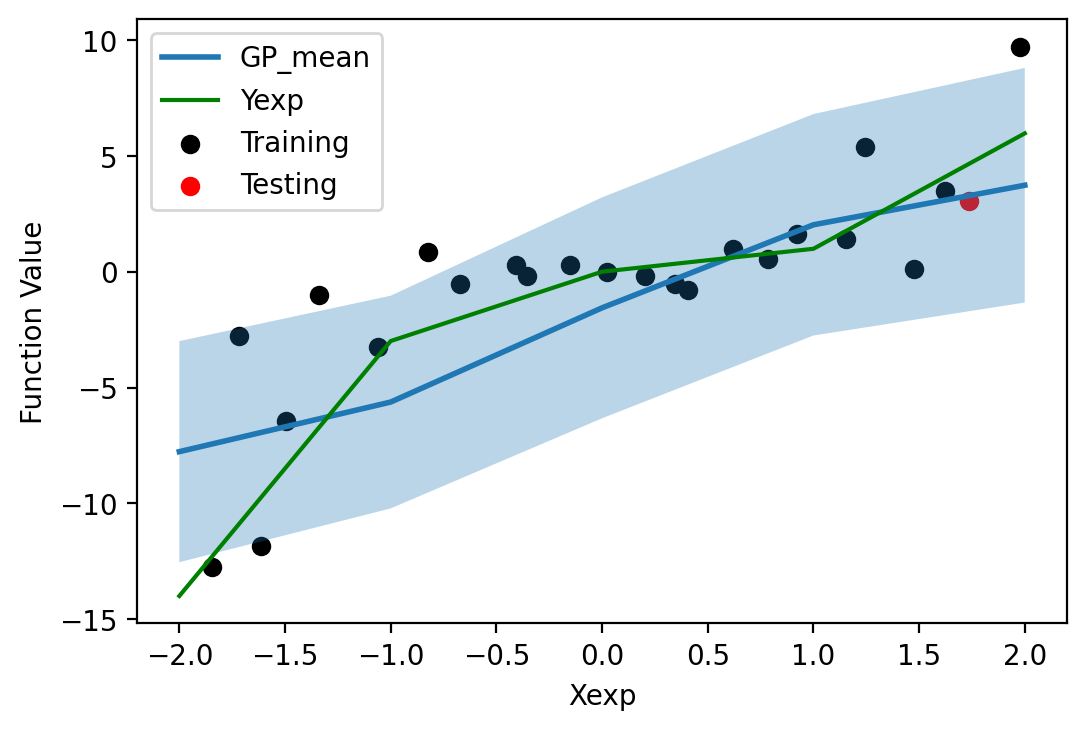

Run Number:  6
Test point is: [ 0.67008959 -0.67689366  1.15495975]


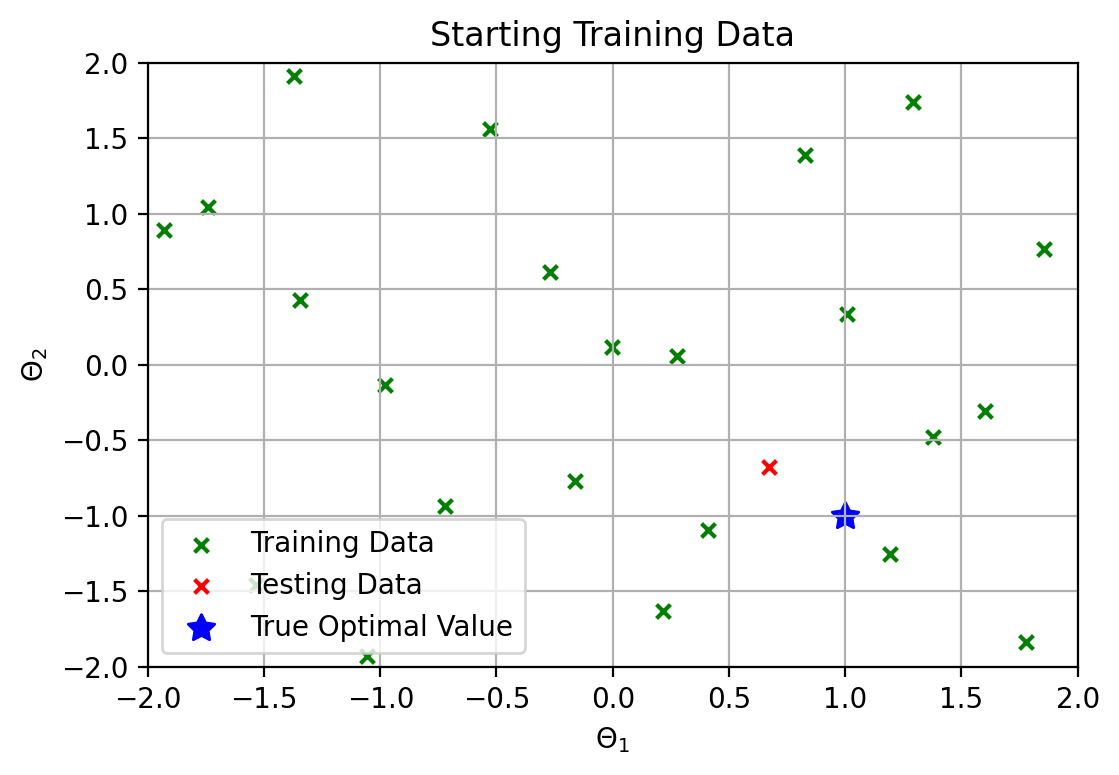

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


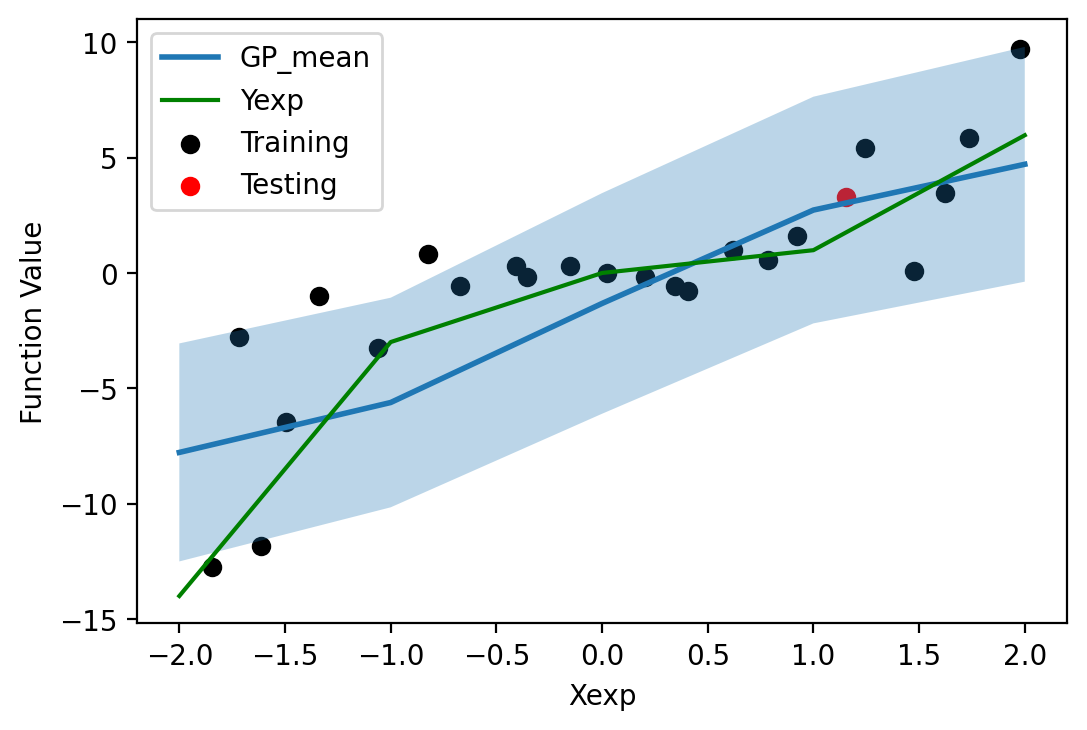

Run Number:  7
Test point is: [-0.2686372   0.61656361 -1.71686129]


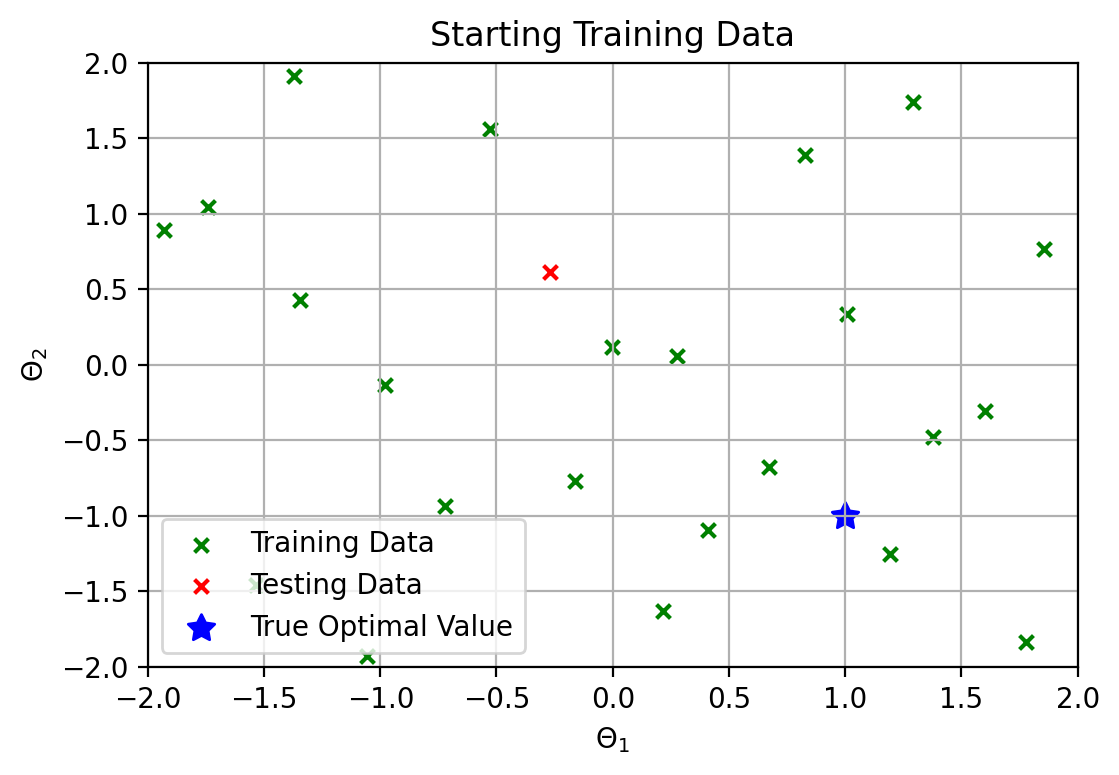

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


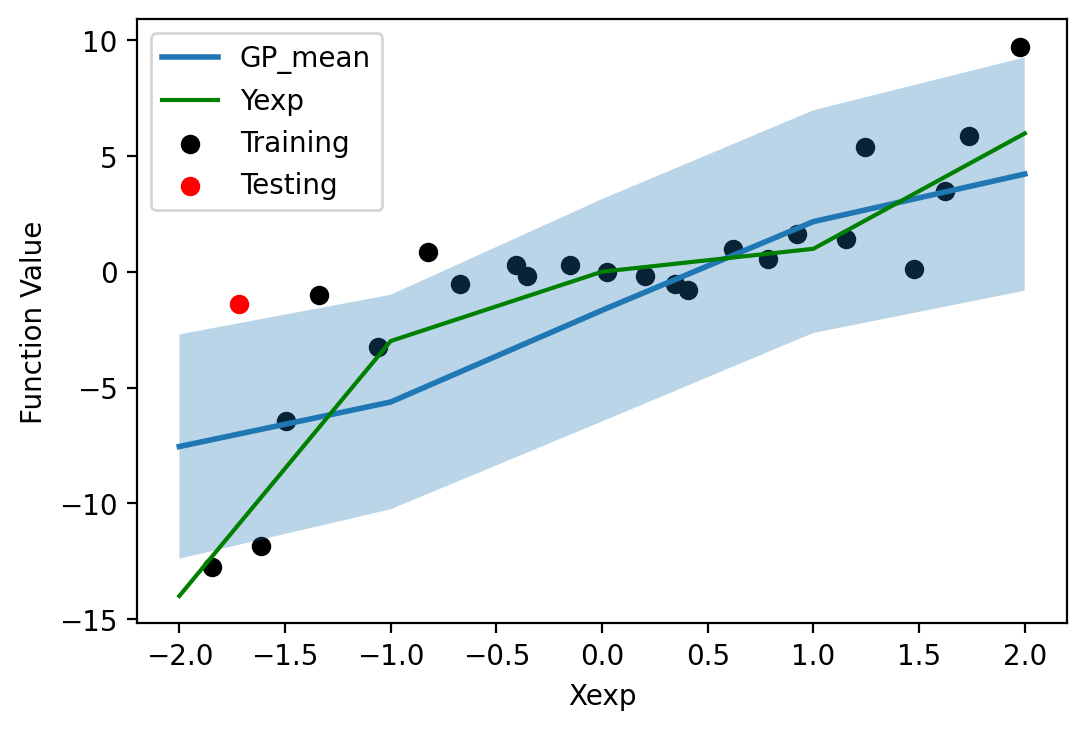

Run Number:  8
Test point is: [ 0.82576709  1.38669568 -0.35378057]


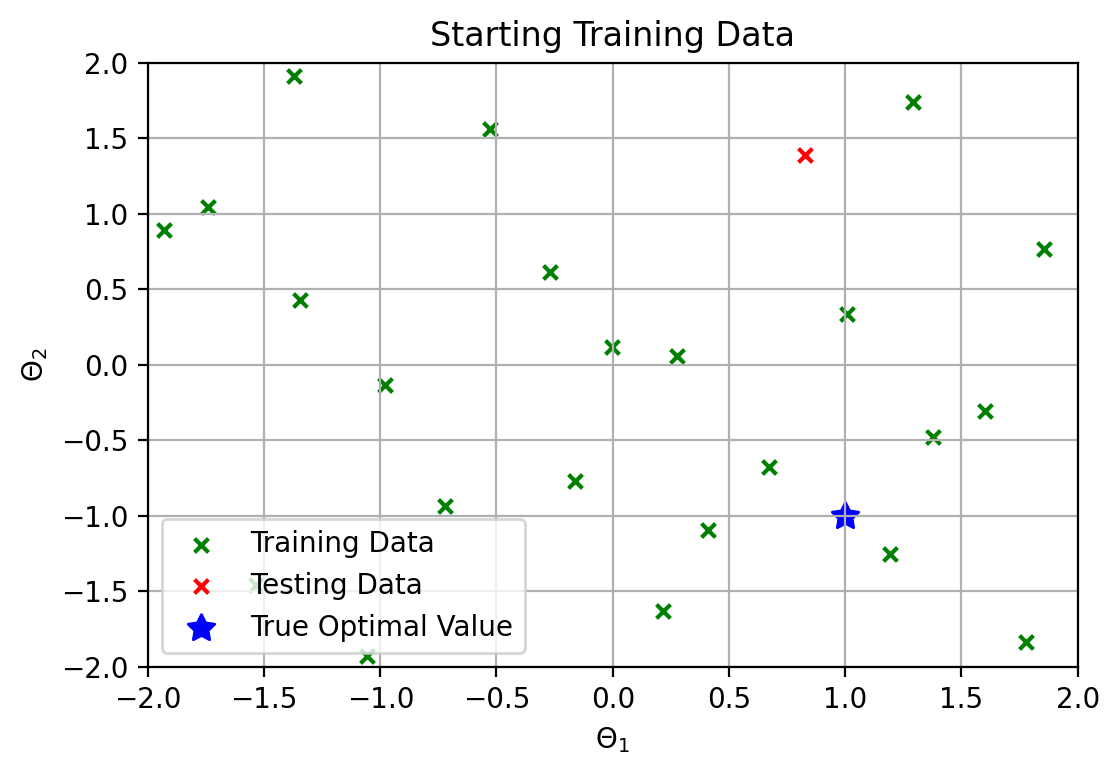

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


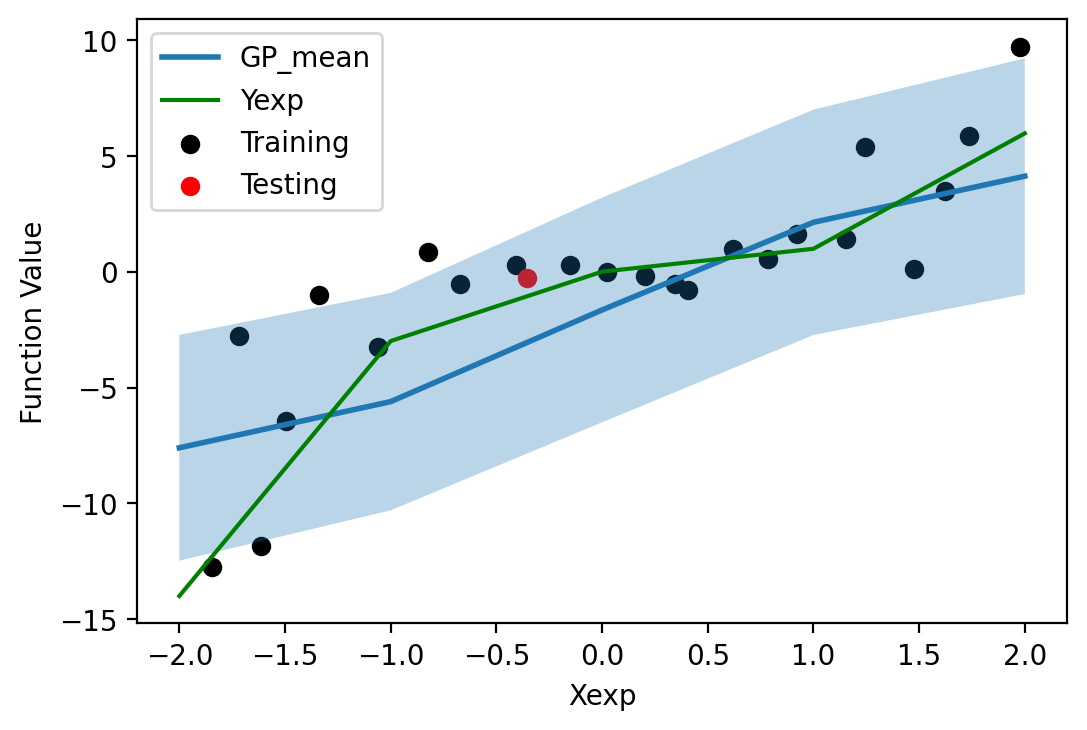

Run Number:  9
Test point is: [1.0063767  0.33627484 0.62006833]


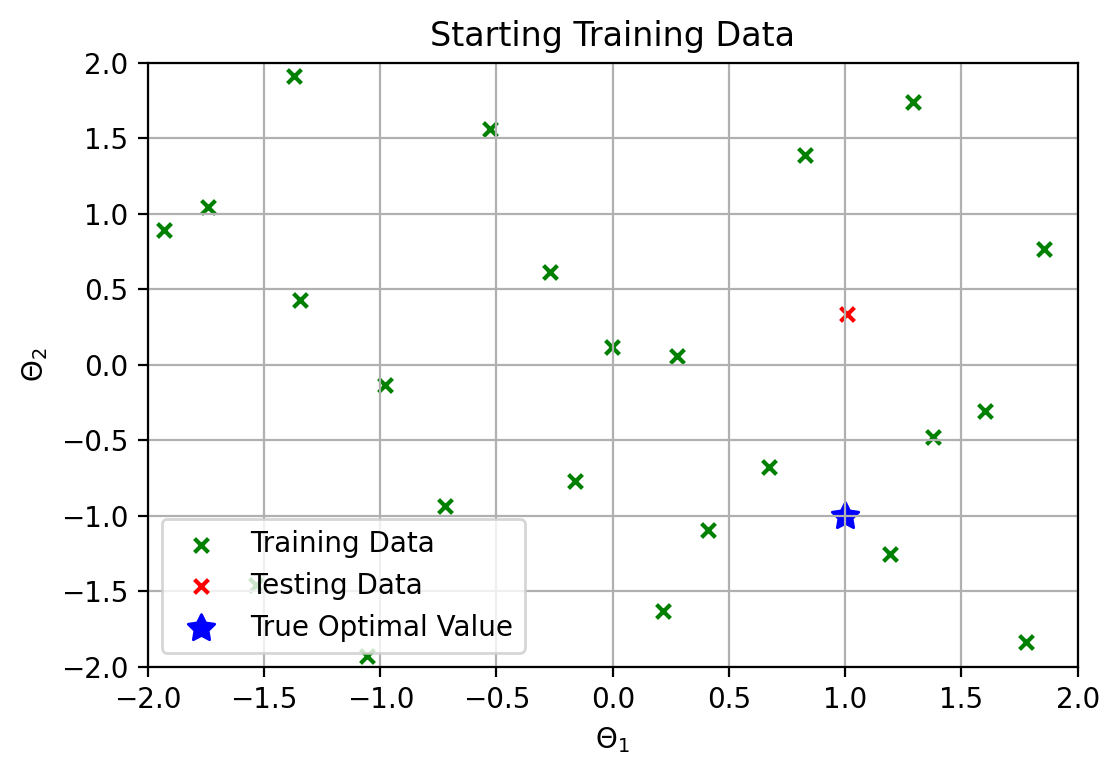

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


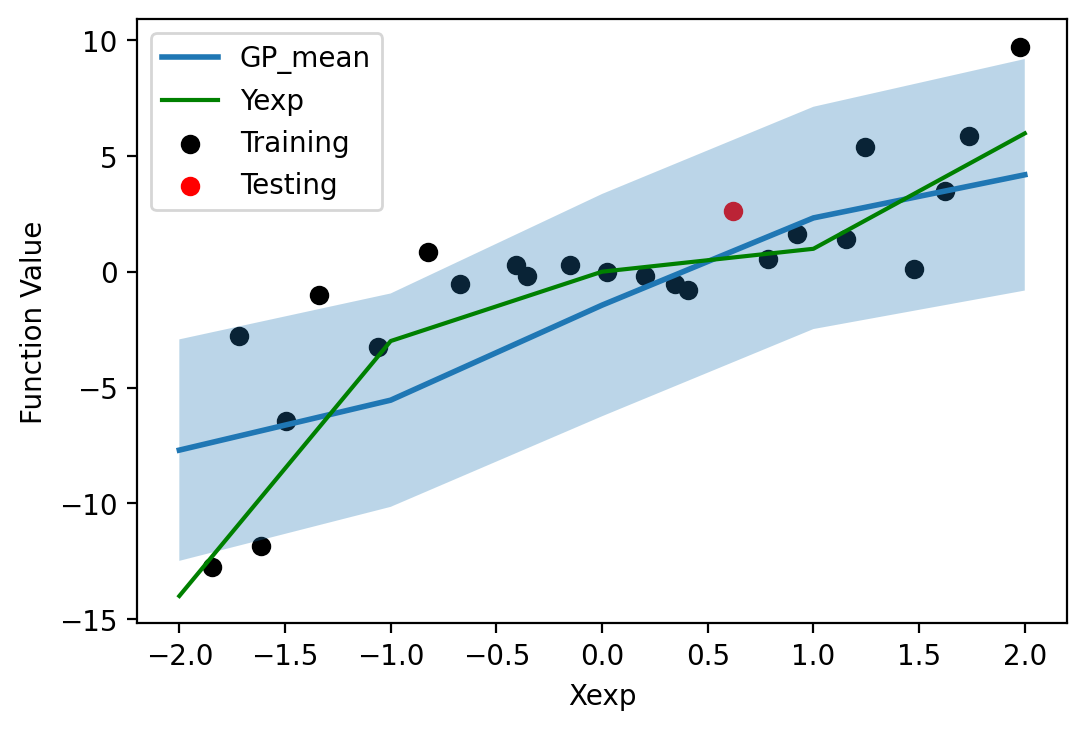

Run Number:  10
Test point is: [-0.0016244   0.12002845  0.78550262]


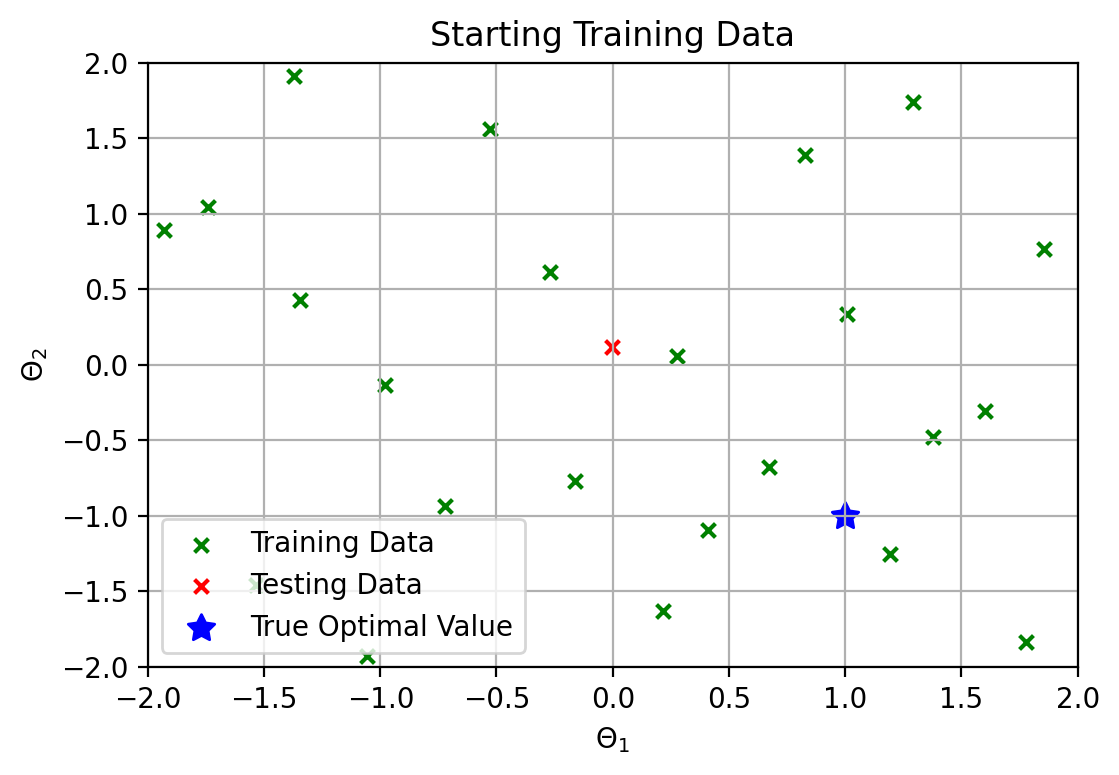

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


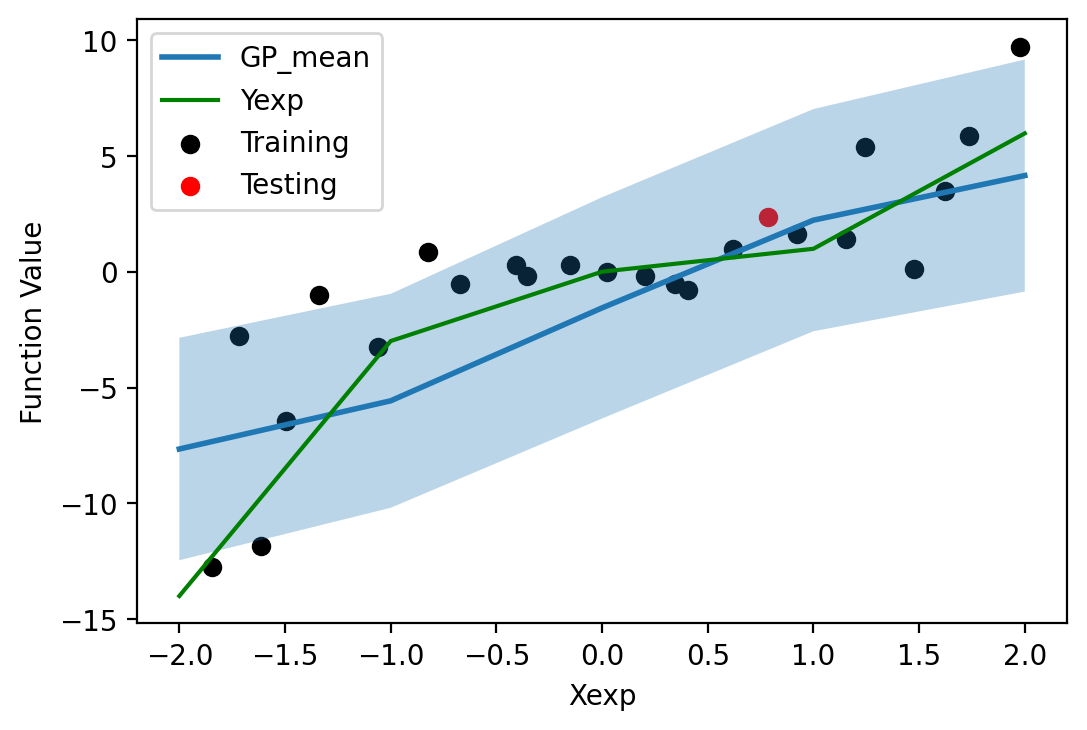

Run Number:  11
Test point is: [-1.34501829  0.42636472 -0.82567007]


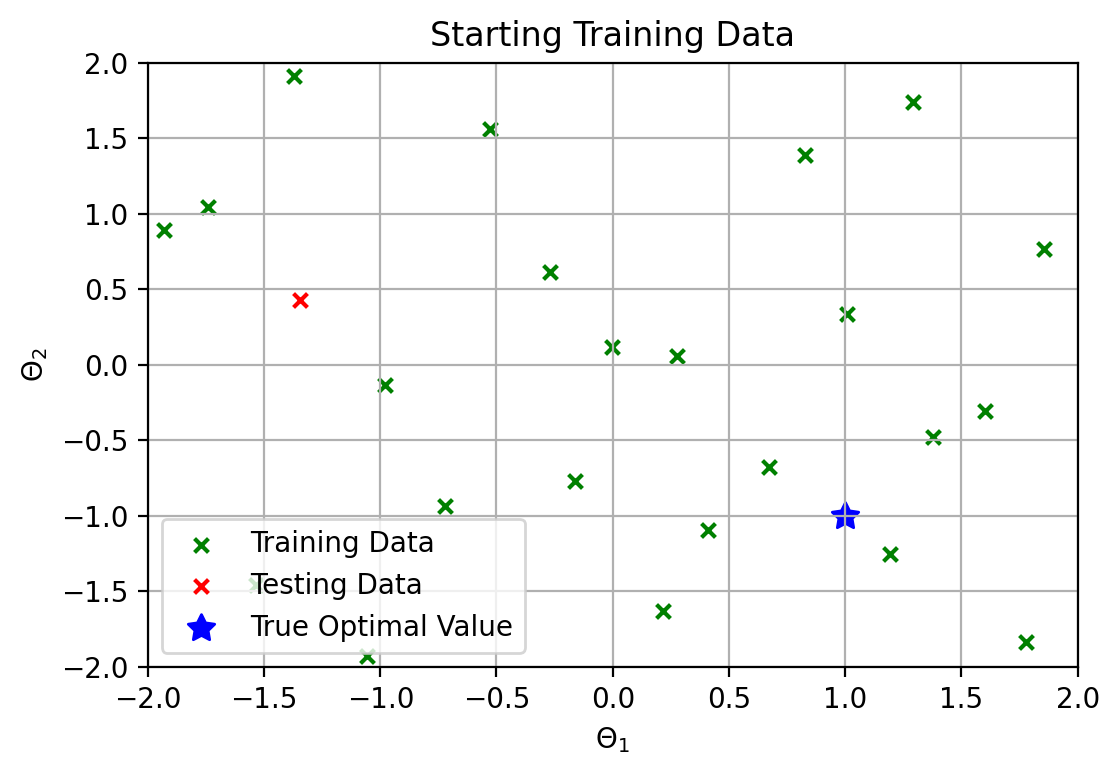

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


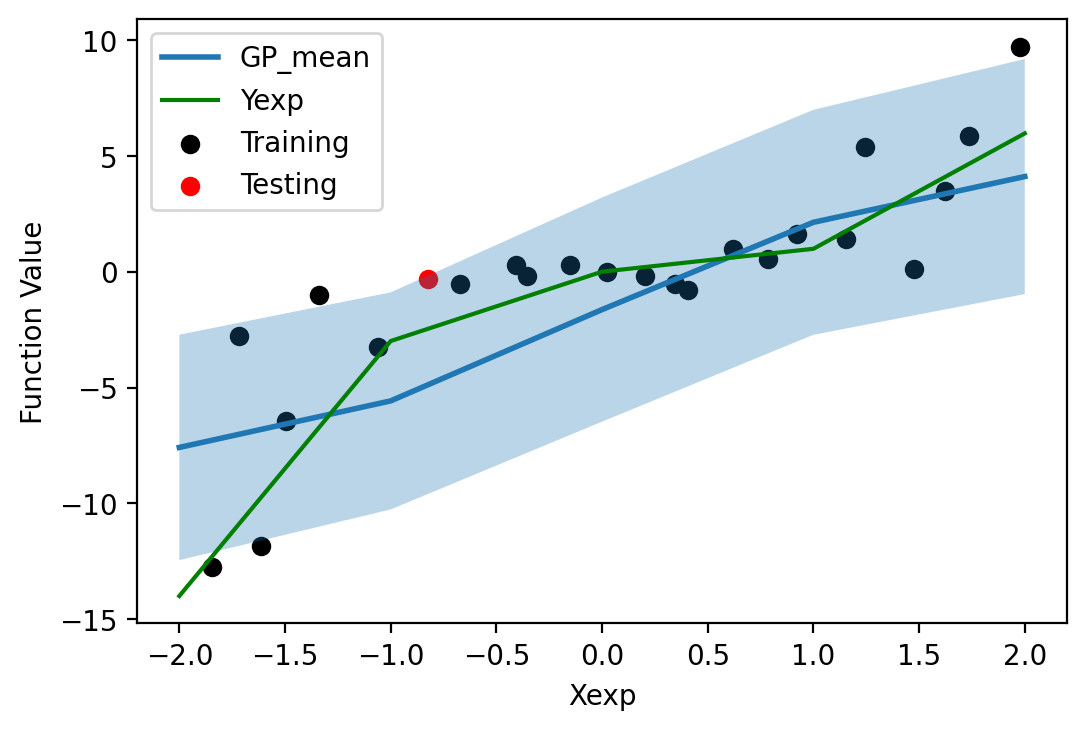

Run Number:  12
Test point is: [-0.98062783 -0.13159366 -0.40760875]


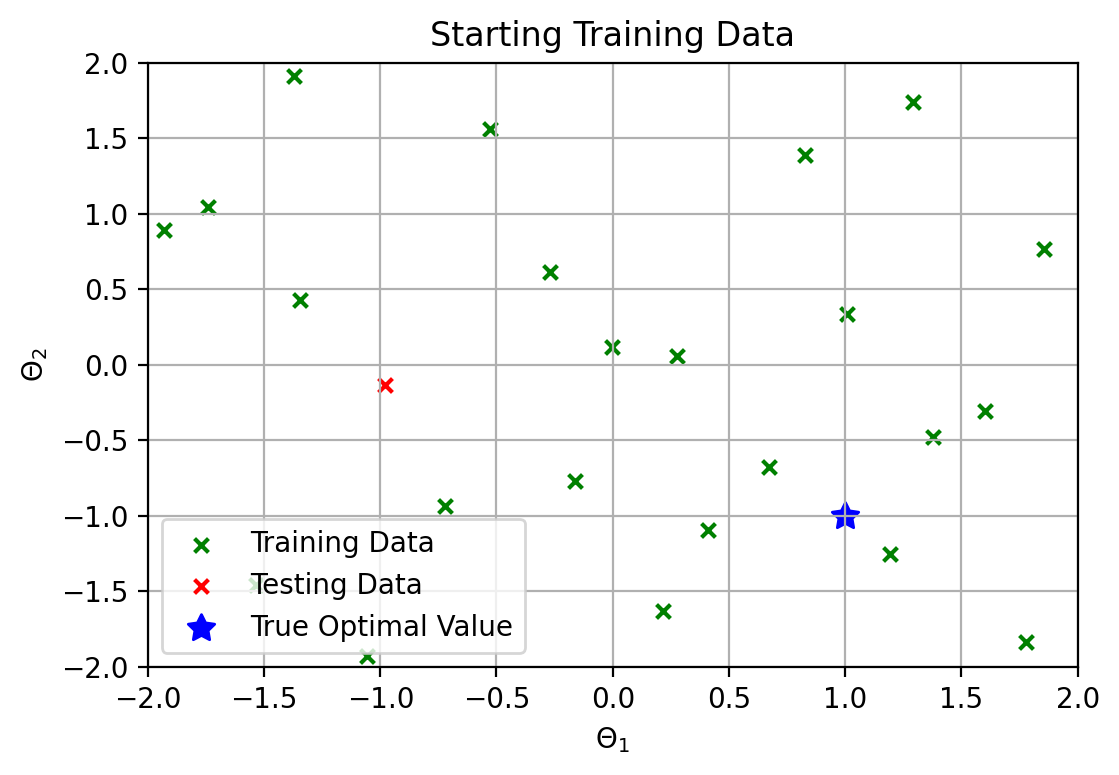

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


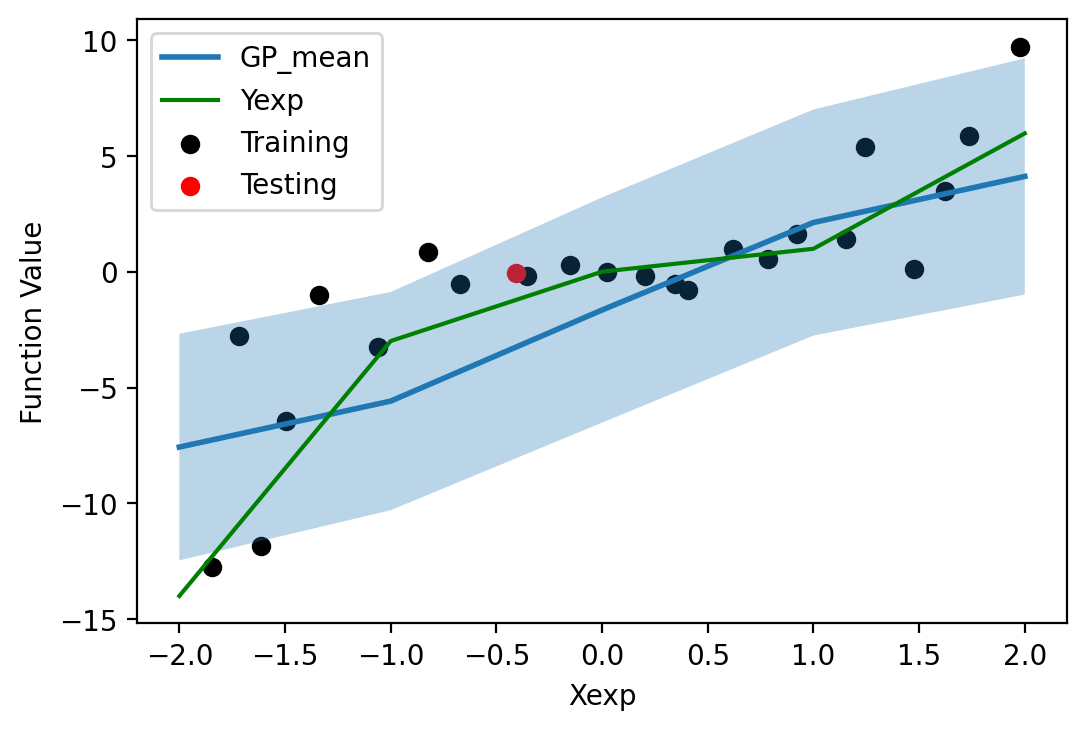

Run Number:  13
Test point is: [-1.05624542 -1.92836186  0.34419443]


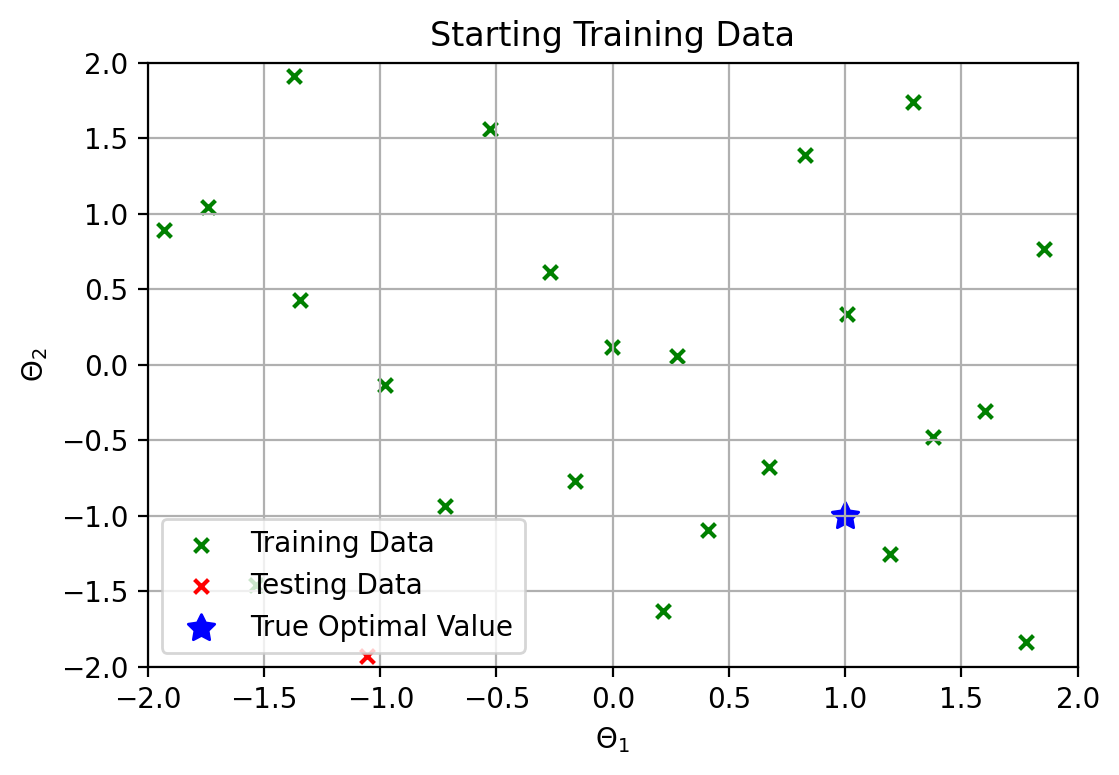

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


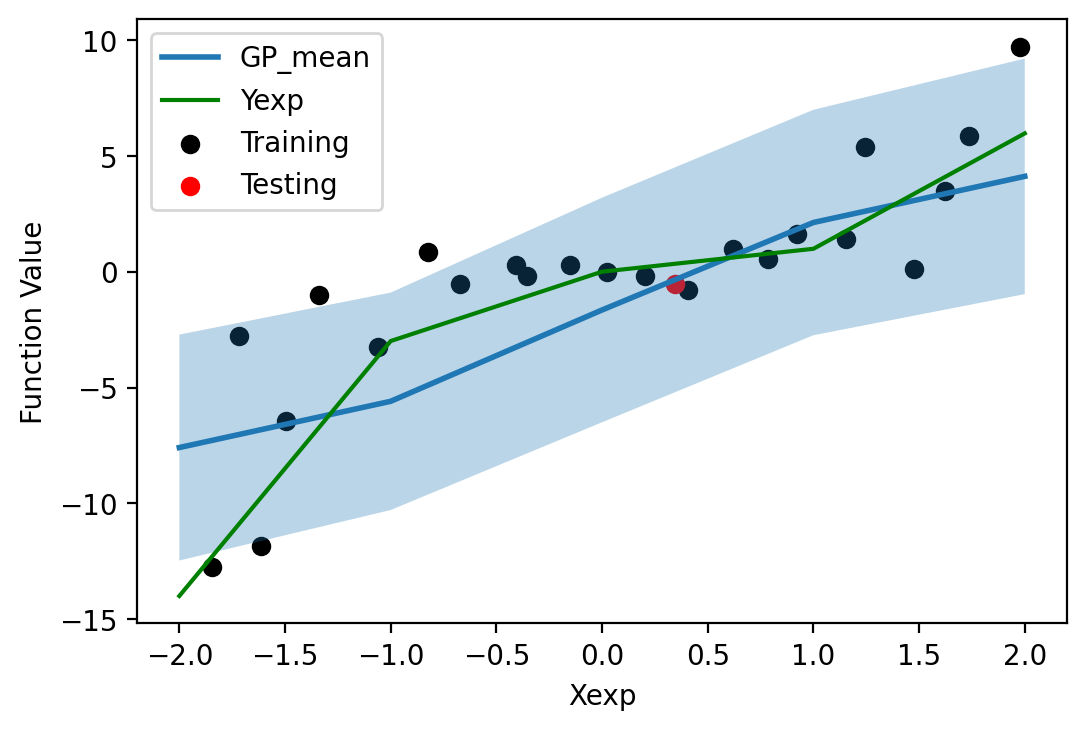

Run Number:  14
Test point is: [-1.74253676  1.04333934 -0.15221449]


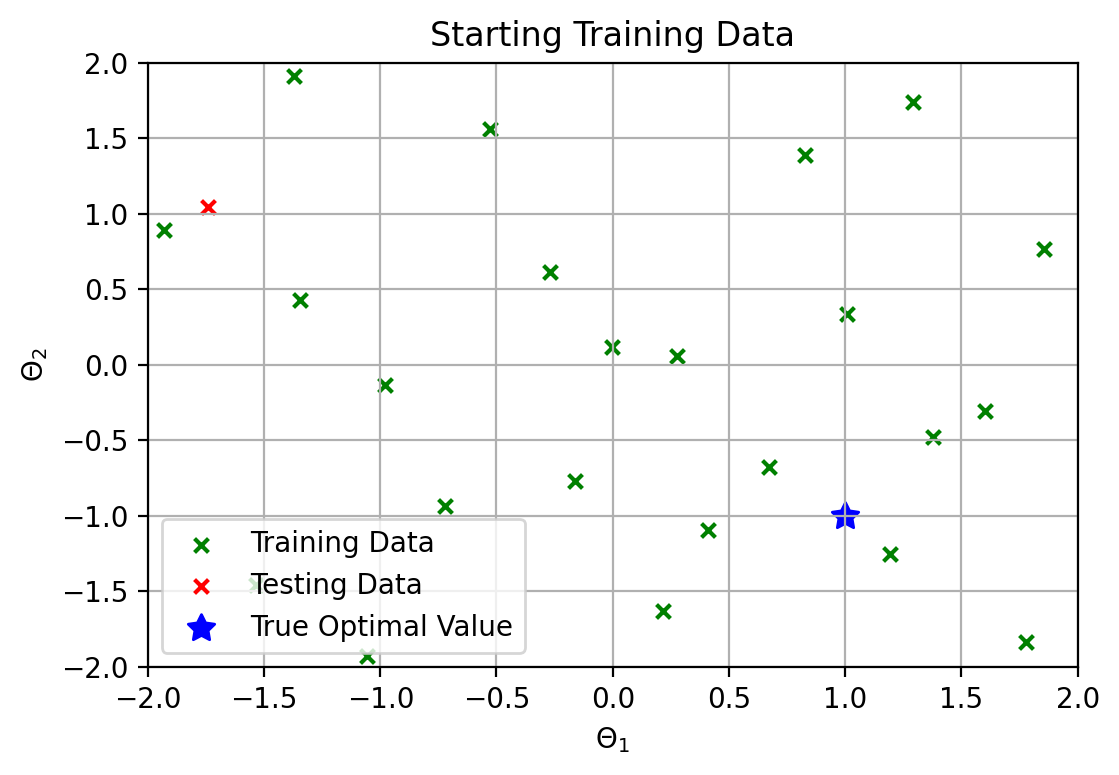

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


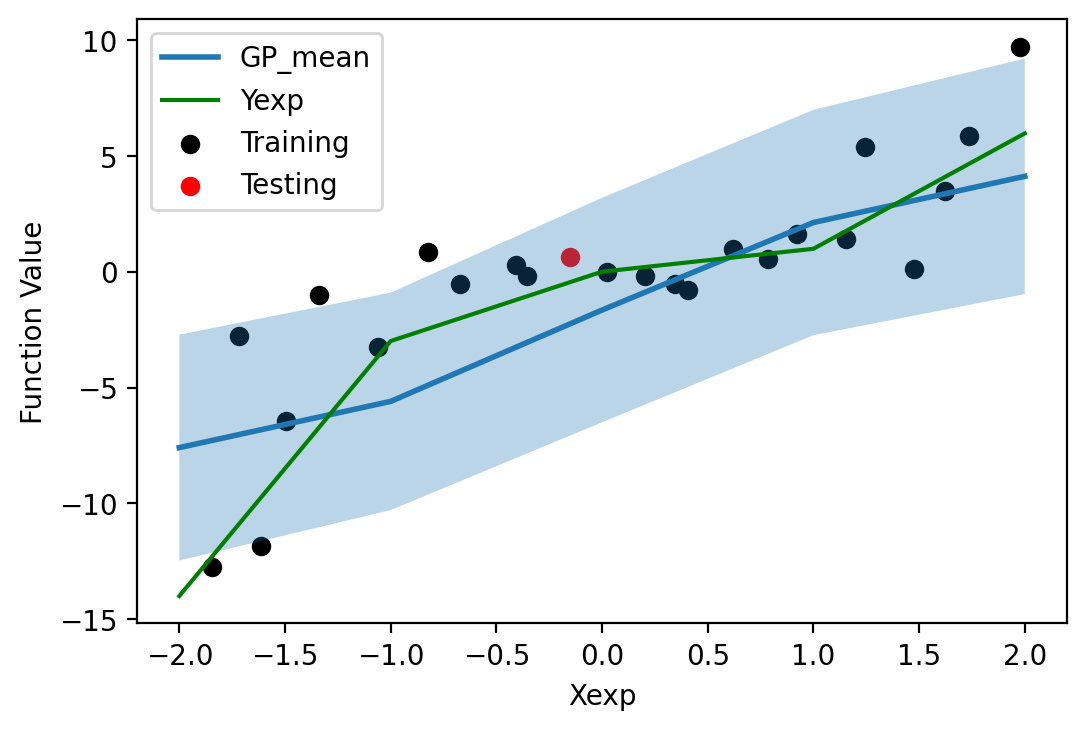

Run Number:  15
Test point is: [-1.36873866  1.91211063  0.2014552 ]


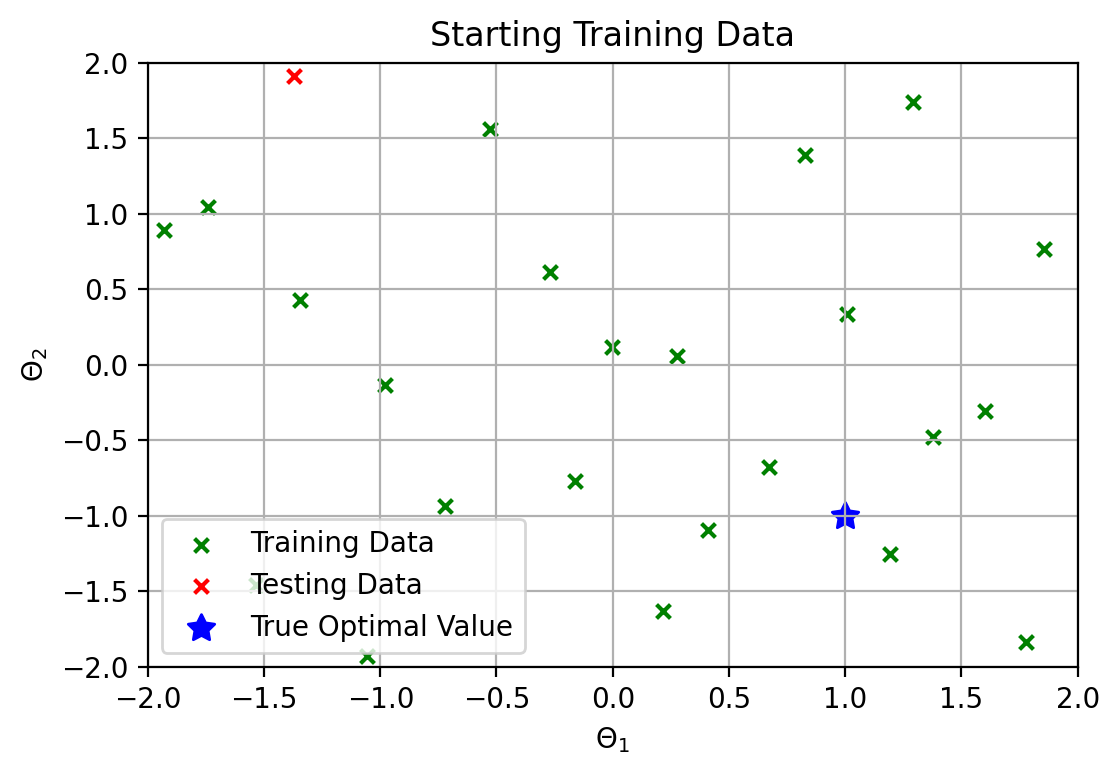

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


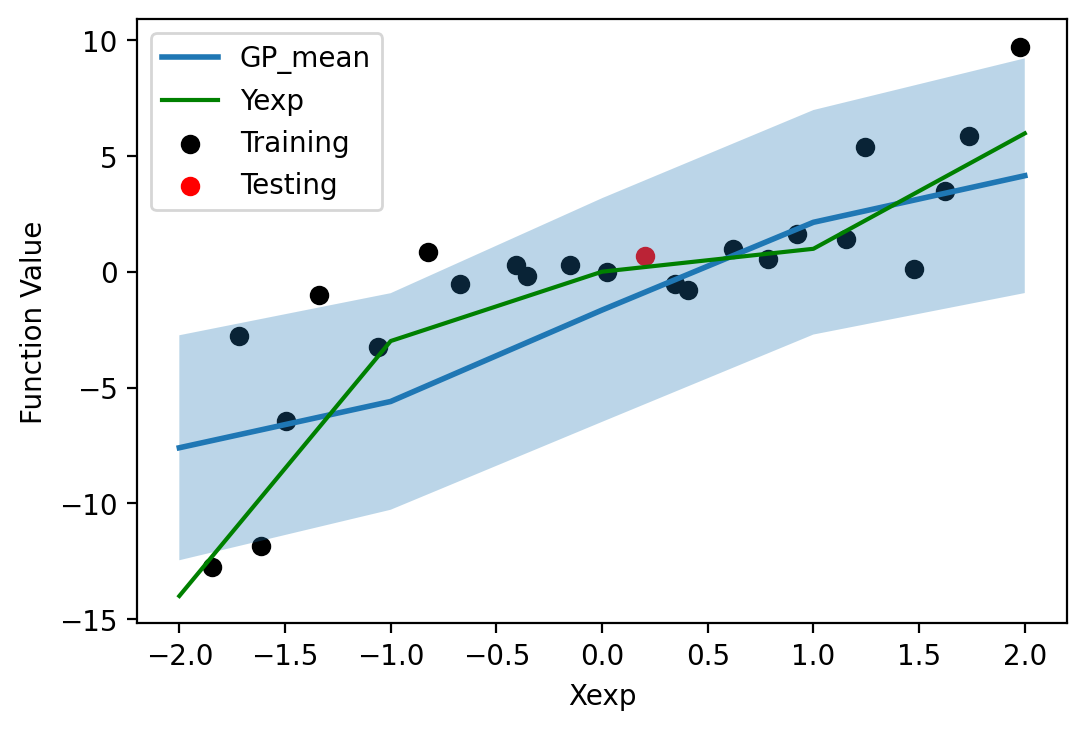

Run Number:  16
Test point is: [-0.16020527 -0.77286778 -0.6744072 ]


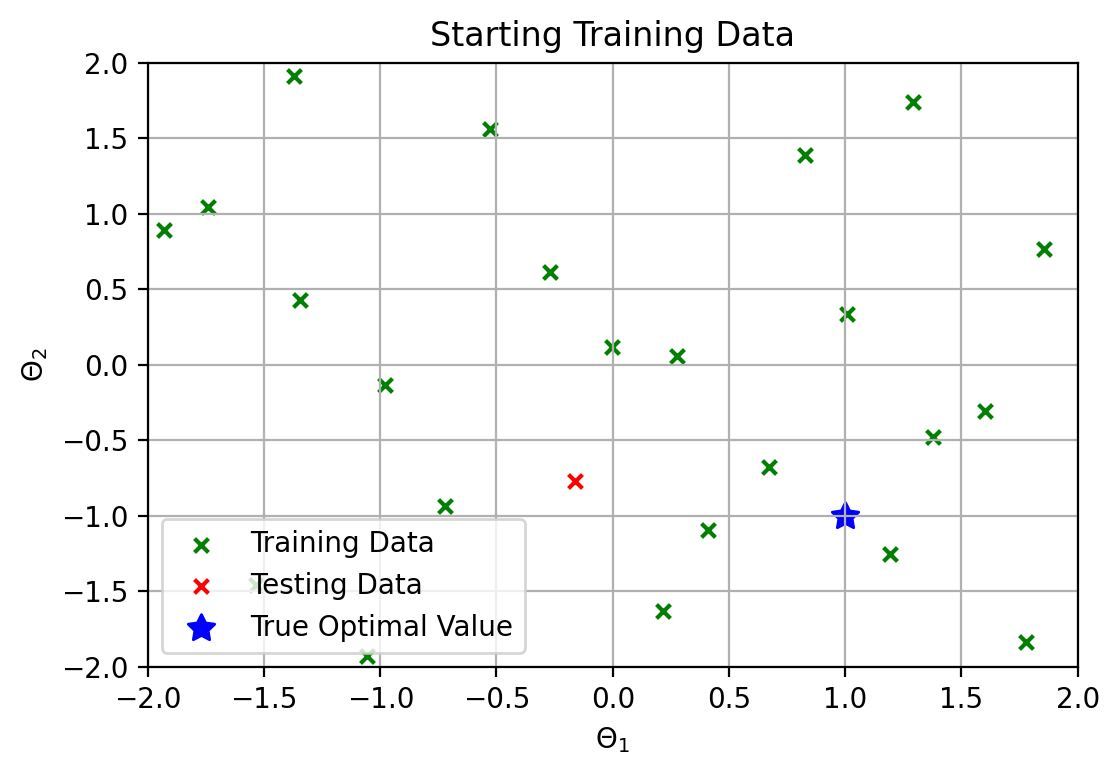

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


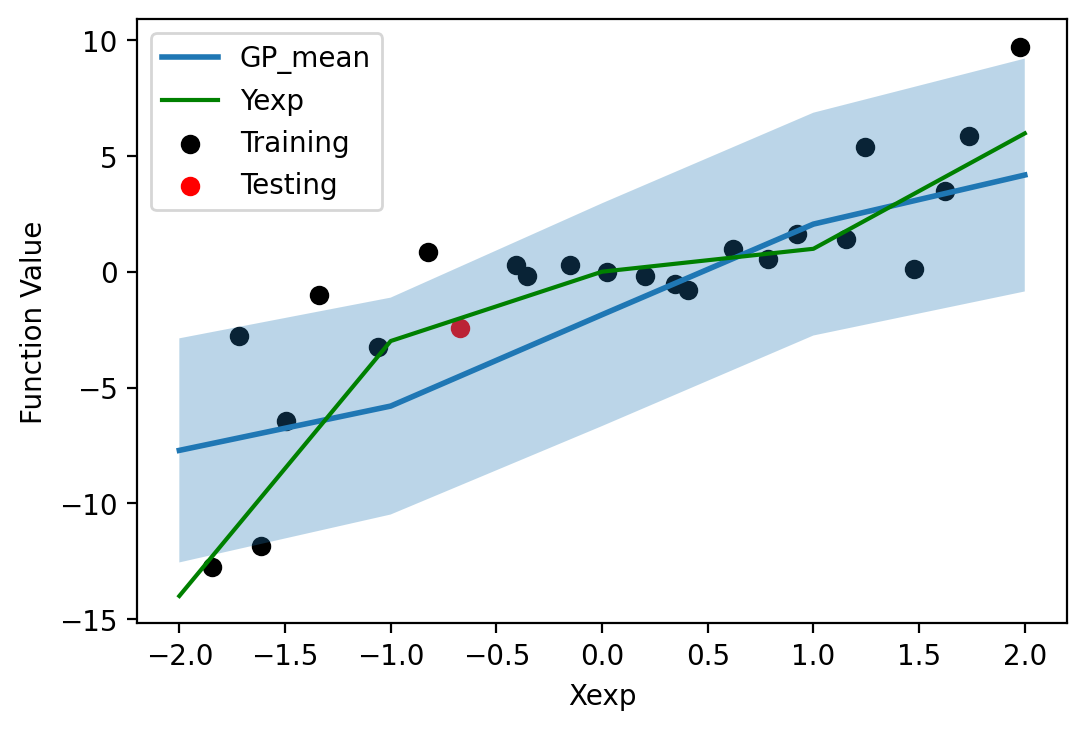

Run Number:  17
Test point is: [ 1.29092461  1.74088455 -1.33698917]


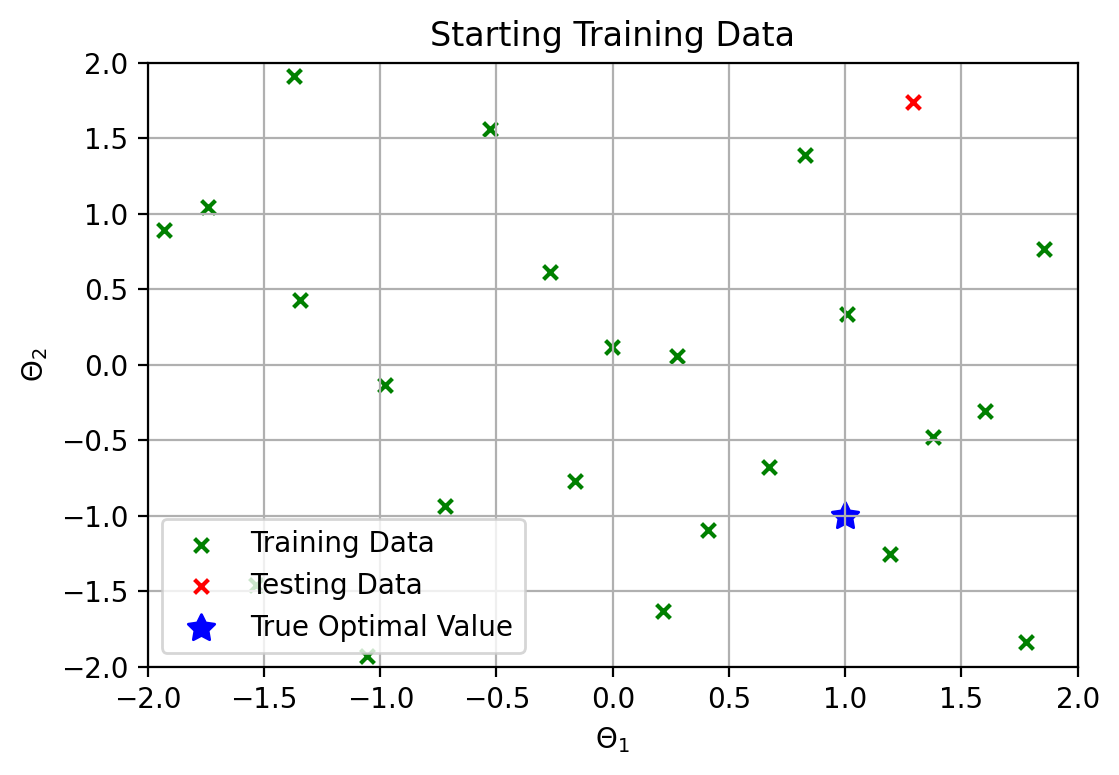

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


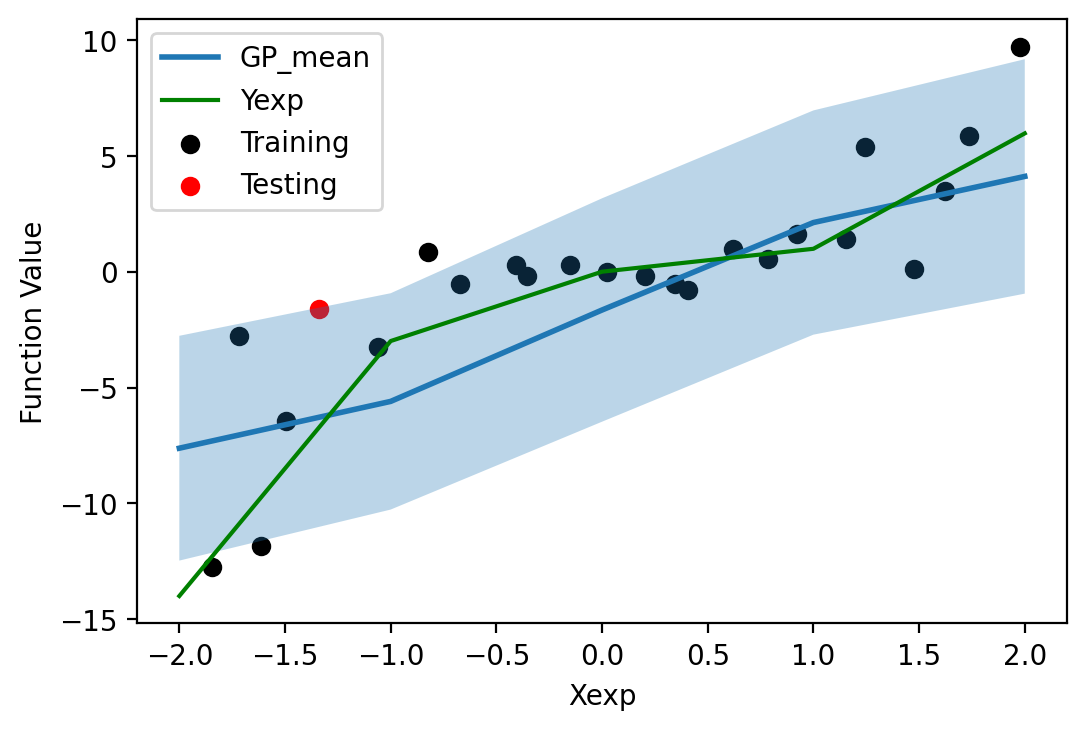

Run Number:  18
Test point is: [-0.71960966 -0.93770185  1.47495877]


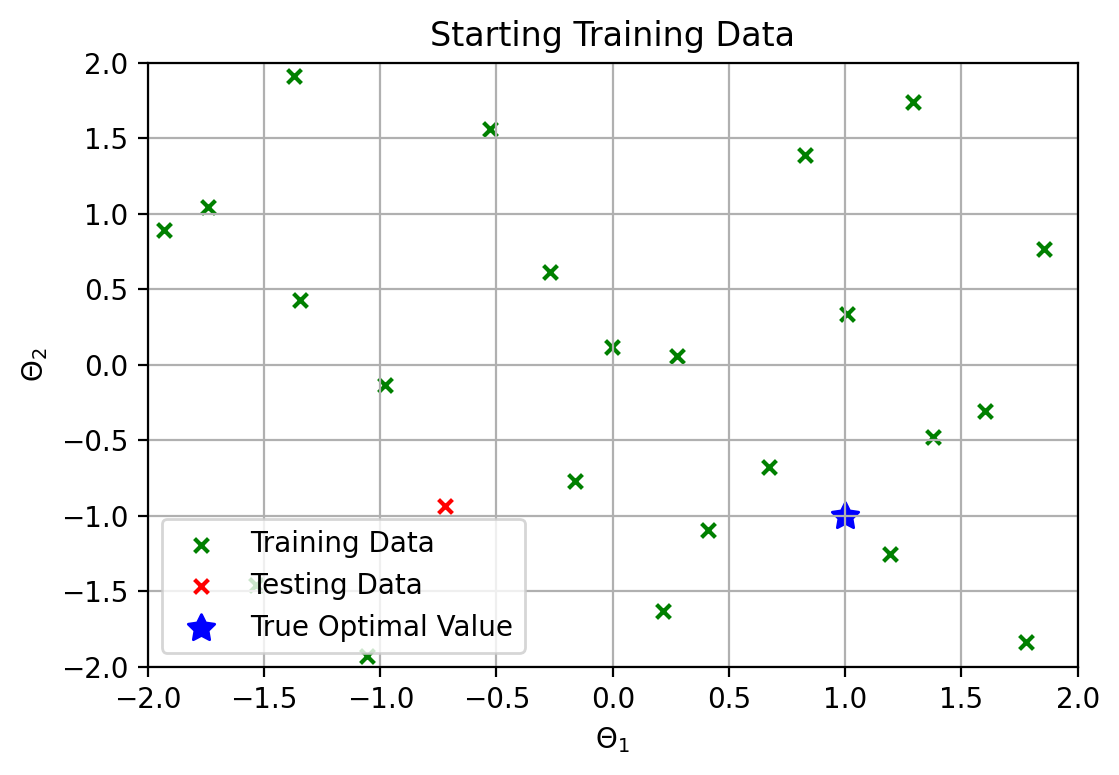

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


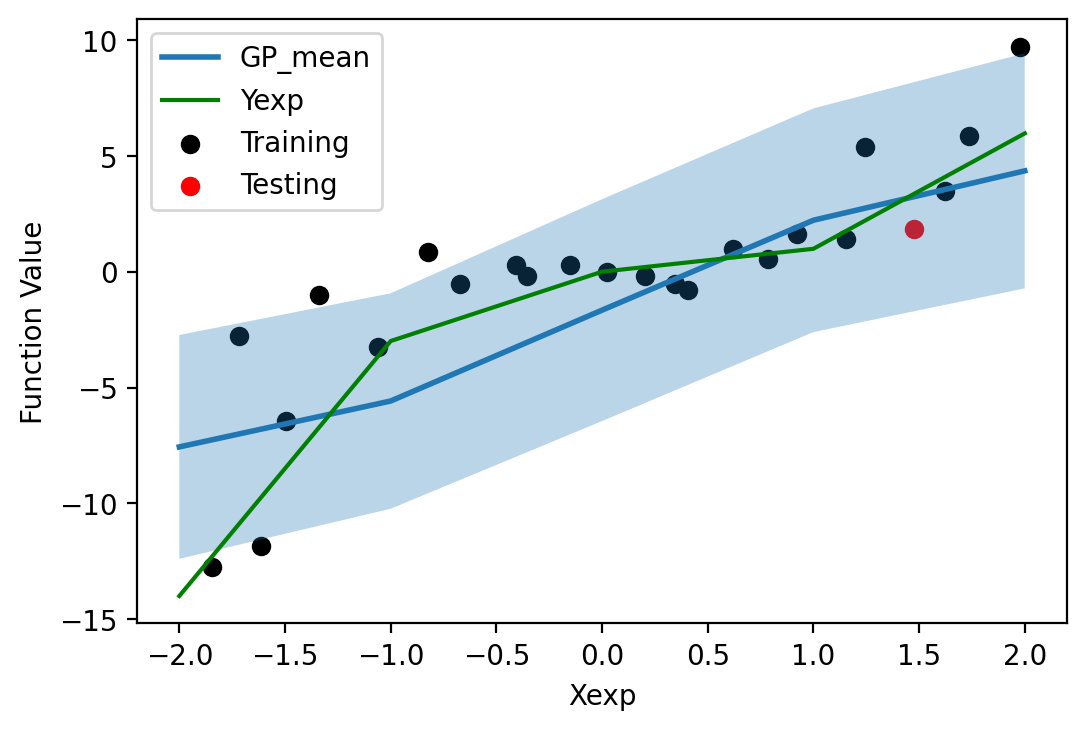

Run Number:  19
Test point is: [-0.52985641  1.55895847  0.92303187]


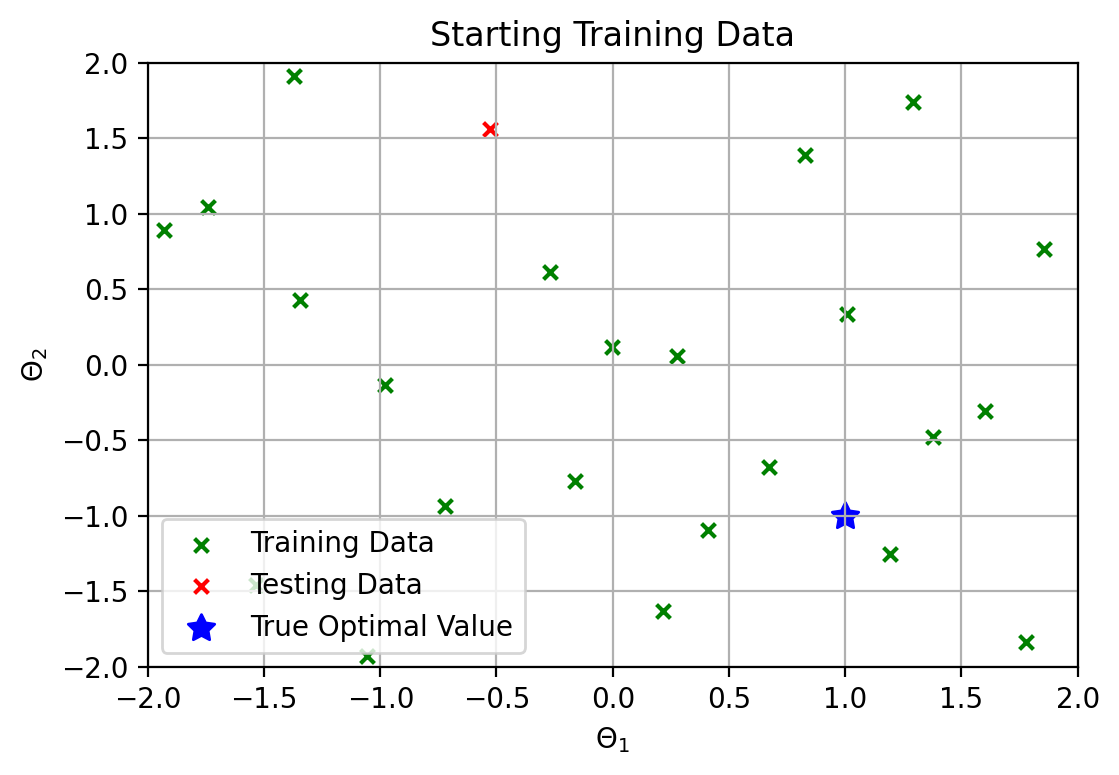

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


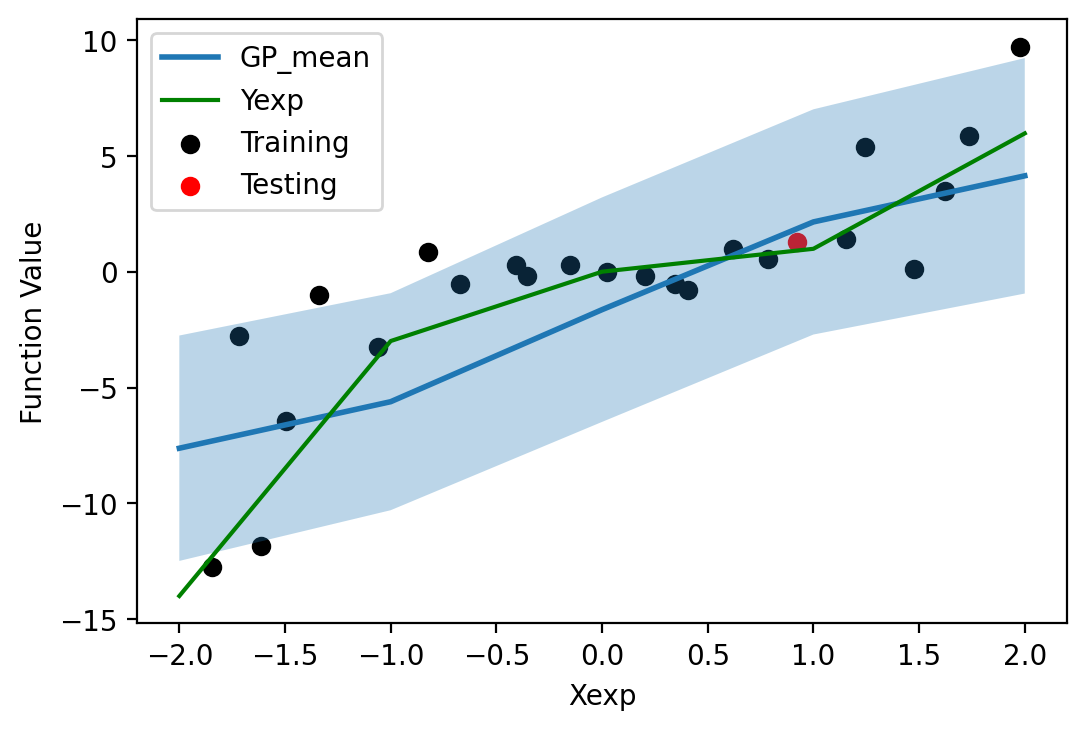

Run Number:  20
Test point is: [ 1.60229573 -0.30622412  1.97795794]


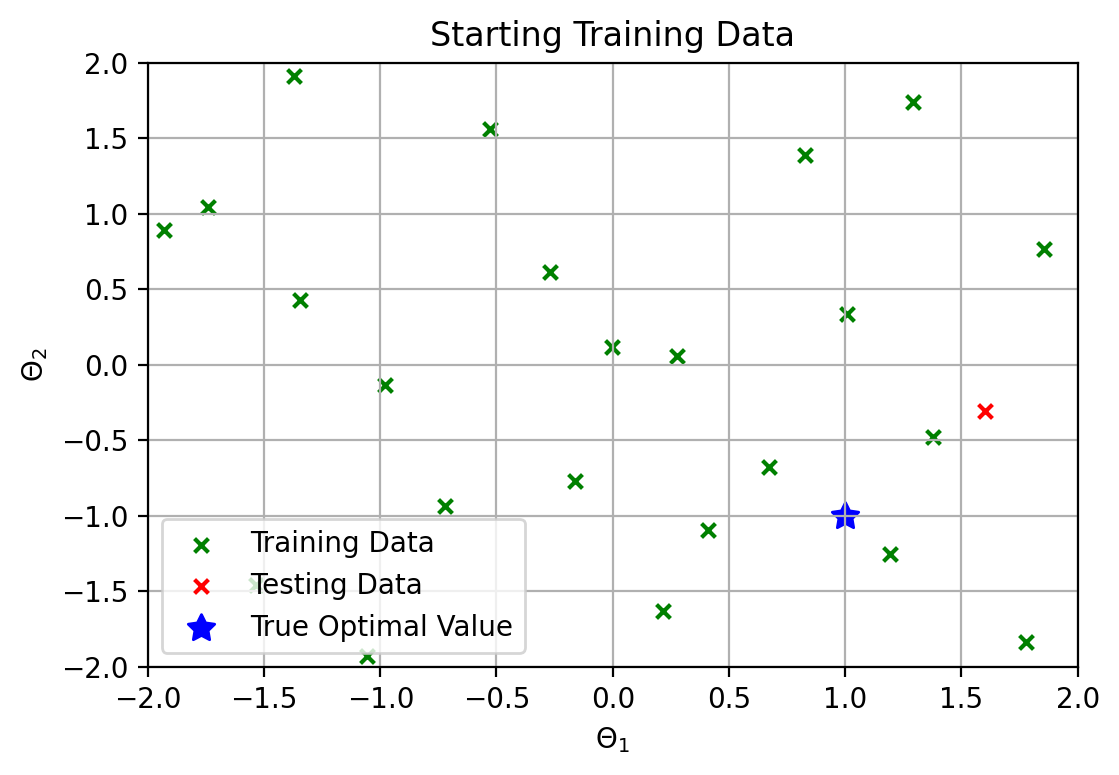

BO Iteration =  1
Showing X/Y Plot for Theta =  [ 0.94736842 -0.94736842] On the Meshgrid.


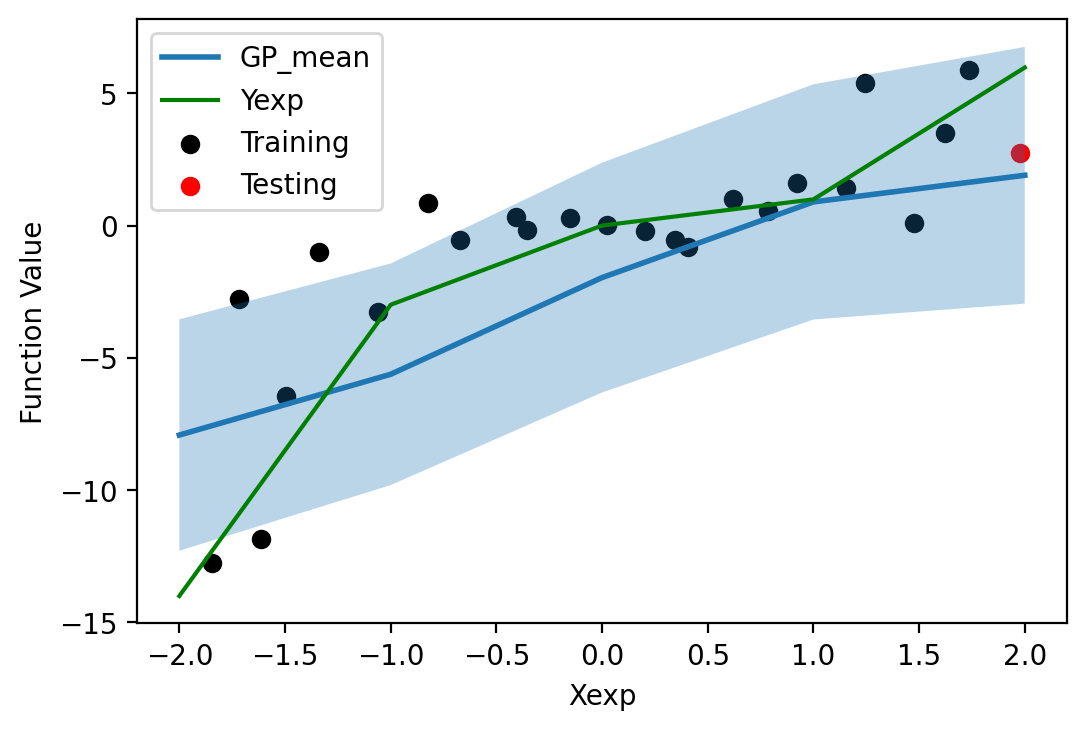

CPU times: user 1min 41s, sys: 393 ms, total: 1min 41s
Wall time: 1min 42s


In [3]:
%%time
obj = "obj"

all_data_doc = "Input_CSVs/Train_Data/all_3_data/t=25.csv"
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

t = len(all_data)

print("Runs:", runs)
print("BO Iters:",BO_iters)
print("------------------------------")

print("Lengthscale Set To:", set_lengthscale)
print("Explore Bias:", str(np.round(float(explore_bias[0]),3)))
results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[0], Xexp, Yexp,
                                 noise_std, obj, runs, sparse_grid, emulator, set_lengthscale, verbose, 
                                 save_fig, shuffle_seed, DateTime)